In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lmfit

### Define Resonator Model

In [2]:
def linear_resonator2(f, f_0, Q, Q_e_real, Q_e_imag):
    Q_e = Q_e_real + 1j*Q_e_imag
    return 1 - (Q * Q_e**-1 / (1 + 2j * Q * (f - f_0) / f_0))

In [3]:
class ResonatorModel2(lmfit.model.Model):
    __doc__ = "resonator model" + lmfit.models.COMMON_DOC

    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later.
        super().__init__(linear_resonator2, *args, **kwargs)

        #self.set_param_hint('Q', min=0)  # Enforce Q is positive
        #self.set_param_hint('phi_0', min=0, max=2*np.pi)
        #self.set_param_hint('t_v', min=0, max=2*np.pi)

    def guess(self, data, f=None, **kwargs):
        verbose = kwargs.pop('verbose', None)
        if f is None:
            return
        argmin_s21 = np.abs(data).argmin()
        fmin = f.min()
        fmax = f.max()
        f_0_guess = f[argmin_s21]  # guess that the resonance is the lowest point
        Q_min = 0.1 * (f_0_guess/(fmax-fmin))  # assume the user isn't trying to fit just a small part of a resonance curve.
        delta_f = np.diff(f)  # assume f is sorted
        min_delta_f = delta_f[delta_f > 0].min()
        Q_max = f_0_guess/min_delta_f  # assume data actually samples the resonance reasonably
        Q_guess = np.sqrt(Q_min*Q_max)  # geometric mean, why not?
        Q_e_real_guess = Q_guess/(1-np.abs(data[argmin_s21]))
        if verbose:
            print("fmin=", fmin, "fmax=", fmax, "f_0_guess=", f_0_guess)
            print("Qmin=", Q_min, "Q_max=", Q_max, "Q_guess=", Q_guess, "Q_e_real_guess=", Q_e_real_guess)
        params = self.make_params(Q=Q_guess, Q_e_real=Q_e_real_guess, Q_e_imag=0, f_0=f_0_guess)
        #params['%sQ' % self.prefix].set(min=Q_min, max=Q_max)
        params['%sf_0' % self.prefix].set(min=fmin, max=fmax)
        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)

### Load Data from the One Hanger Impedance Analysis (See notebook)

In [4]:
s21_data = pd.read_csv("s21_data.csv")

In [5]:
s21_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1001 non-null   float64
 1   S11                1001 non-null   object 
 2   S21                1001 non-null   object 
 3   S31                1001 non-null   object 
 4   S12                1001 non-null   object 
 5   S22                1001 non-null   object 
 6   S32                1001 non-null   object 
 7   S13                1001 non-null   object 
 8   S23                1001 non-null   object 
 9   S33                1001 non-null   object 
 10  20_log_of_mag_S11  1001 non-null   float64
 11  20_log_of_mag_S21  1001 non-null   float64
 12  20_log_of_mag_S31  1001 non-null   float64
 13  degrees_S11        1001 non-null   float64
 14  degrees_S21        1001 non-null   float64
 15  degrees_S31        1001 non-null   float64
dtypes: float64(7), object(9)

In [6]:
s21_data = s21_data.rename(columns={"Unnamed: 0":"frequency"})

In [7]:
s21 = s21_data.S21.to_numpy(dtype ='cfloat')
s21[0]

(-0.867414667392116+0.495742666261647j)

In [8]:
len(s21_data)

1001

#### Some Utilities

In [9]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.imag, data.real, *args, **kwargs)

In [10]:
def normalize_complex_arr(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

### A Look at the Data

In [11]:
freq = s21_data.frequency.to_numpy()
freq 

array([4.   , 4.001, 4.002, ..., 4.998, 4.999, 5.   ])

In [12]:
ns21 = normalize_complex_arr(s21)

Text(0.5, 0, 'GHz')

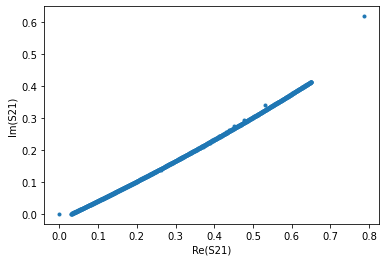

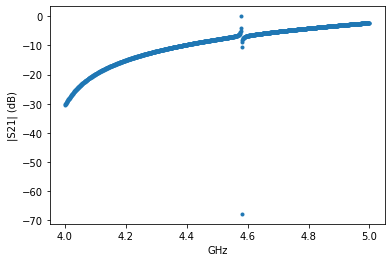

In [13]:
plt.figure()
plot_ri(ns21, '.')
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(freq, 20*np.log10(np.abs(ns21)), '.')
plt.ylabel('|S21| (dB)')
plt.xlabel('GHz')

#### Range maybe too wide, focus on "notch"

Text(0.5, 0, 'GHz')

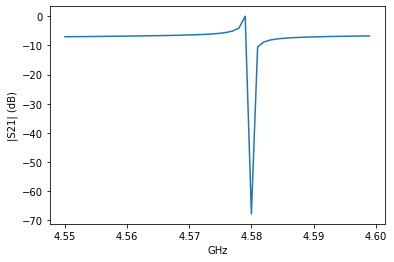

In [14]:

plt.figure()
plt.plot(freq[550:600], 20*np.log10(np.abs(ns21[550:600])), '-')
plt.ylabel('|S21| (dB)')
plt.xlabel('GHz')

### Now try the Resonator Model
#### First using the guess() of the model

In [15]:
resonator1 = ResonatorModel2()
guess_params = resonator1.guess(ns21[550:600], f=freq[550:600], verbose=True)

fmin= 4.55 fmax= 4.599 f_0_guess= 4.58
Qmin= 9.346938775510132 Q_max= 4580.000000002538 Q_guess= 206.90330976535907 Q_e_real_guess= 206.9880998194861


In [16]:
result = resonator1.fit(ns21[550:600], params=close_params, f=freq[550:600], verbose=True)

print(result.fit_report() + '\n')
result.params.pretty_print()

NameError: name 'close_params' is not defined

In [ ]:
fit_s21 = resonator1.eval(params=result.params, f=freq[550:600])
guess_s21 = resonator1.eval(params=guess_params, f=freq[550:600])

plt.figure()
plot_ri(ns21[550:600], '.')
plot_ri(fit_s21, 'r.-', label='best fit')
plot_ri(guess_s21, 'k--', label='initial fit')
plt.legend(loc='best')
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(freq[550:600], 20*np.log10(np.abs(ns21[550:600])), '.')
plt.plot(freq[550:600], 20*np.log10(np.abs(fit_s21)), 'r.-', label='best fit')
#plt.plot(freq, 20*np.log10(np.abs(guess_s21)), 'k--', label='initial fit')
plt.legend(loc='best')
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')

#### Making my own starting params

In [ ]:
resonator2 = ResonatorModel2()
#close_params = resonator2.make_params(f_0=4.58, Q=50000000, Q_e_real=100, Q_e_imag=-1000)
close_params = resonator2.make_params(f_0=4.58, Q=5e7, Q_e_real=500, Q_e_imag=-2000)

In [ ]:
result = resonator2.fit(ns21[550:600], params=close_params, f=freq[550:600], verbose=True)

print(result.fit_report() + '\n')
result.params.pretty_print()

In [ ]:
fit_s21 = resonator2.eval(params=result.params, f=freq[550:600])
guess_s21 = resonator2.eval(params=close_params, f=freq[550:600])

plt.figure()
plot_ri(ns21[550:600], '.')
plot_ri(fit_s21, 'r.-', label='best fit')
#plot_ri(guess_s21, 'k--', label='initial fit')
plt.legend(loc='best')
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(freq[550:600], 20*np.log10(np.abs(ns21[550:600])), '.')
plt.plot(freq[550:600], 20*np.log10(np.abs(fit_s21)), 'r.-', label='best fit')
#plt.plot(freq, 20*np.log10(np.abs(guess_s21)), 'k--', label='initial fit')
plt.legend(loc='best')
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')